In [117]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import StandardScaler

import gzip
import shutil
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

### Converting the gz file to a csv

In [118]:
gz_file = './Modelling data.gz'
csv_file = './Modelling data.csv'

with gzip.open(gz_file, 'rb') as f_in:
    with open(csv_file, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
print("File has been converted.")


File has been converted.


In [119]:
#Preview the first five rows 
df = pd.read_csv('Modelling data.csv')
df.head()

,NAME,ELEVATION,DATE,WND,AA1,TMP,SLP,DEW
0,"PORT AUTH DOWNTN MANHATTAN WALL ST HEL, NY US",2.13,2017-01-01T00:15:00,6.7,NaN,6.0,1030.0,-20
1,"PORT AUTH DOWNTN MANHATTAN WALL ST HEL, NY US",2.13,2017-01-01T00:35:00,6.2,NaN,6.0,1030.0,-20
2,"PORT AUTH DOWNTN MANHATTAN WALL ST HEL, NY US",2.13,2017-01-01T00:55:00,5.7,NaN,6.0,1030.0,-30
3,"PORT AUTH DOWNTN MANHATTAN WALL ST HEL, NY US",2.13,2017-01-01T00:56:00,6.2,NaN,6.1,NaN,-28
4,"PORT AUTH DOWNTN MANHATTAN WALL ST HEL, NY US",2.13,2017-01-01T01:15:00,5.7,NaN,6.0,1030.0,-20


In [120]:
#View list of columns
df.columns.tolist()

['NAME', 'ELEVATION', 'DATE', 'WND', 'AA1', 'TMP', 'SLP', 'DEW']

In [121]:
#Check for summary of columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120089 entries, 0 to 120088
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   NAME       120089 non-null  object 
 1   ELEVATION  120089 non-null  float64
 2   DATE       120089 non-null  object 
 3   WND        120089 non-null  float64
 4   AA1        22350 non-null   float64
 5   TMP        120089 non-null  float64
 6   SLP        72736 non-null   float64
 7   DEW        120089 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 7.3+ MB


In [122]:
# print(df.isnull().sum())

# print((df == float('inf')).sum())

# df.replace([float('inf'), float('-inf')], float('nan'), inplace=True)
# df.fillna(df.mean(), inplace=True)

# print(df.isnull().sum())
df['AA1'].fillna(0, inplace=True)
df['SLP'].fillna(df['SLP'].mean(), inplace=True)


In [130]:
df['AA1'].value_counts()

0.0    97739
0.1    17870
0.6     1999
2.4     1538
0.3      943
Name: AA1, dtype: int64

## Modelling

### Decision Tree

In [124]:
#Converting the date column to datetime
df['DATE'] = pd.to_datetime(df['DATE'])

#Extracting more columns like year, month, and day
df['year'] = df['DATE'].dt.year
df['month'] = df['DATE'].dt.month
df['day'] = df['DATE'].dt.day

#Drop original date column and name
df = df.drop(columns=['DATE', 'NAME'])



In [125]:
df

,ELEVATION,WND,AA1,TMP,SLP,DEW,year,month,day
0,2.13,6.7,0.0,6.0,1030.000000,-20,2017,1,1
1,2.13,6.2,0.0,6.0,1030.000000,-20,2017,1,1
2,2.13,5.7,0.0,6.0,1030.000000,-30,2017,1,1
3,2.13,6.2,0.0,6.1,1022.013264,-28,2017,1,1
4,2.13,5.7,0.0,6.0,1030.000000,-20,2017,1,1
...,...,...,...,...,...,...,...,...,...
120084,2.13,4.6,0.0,11.7,1010.600000,39,2024,12,31
120085,2.13,3.6,0.0,10.0,1010.100000,44,2024,12,31
120086,2.13,4.6,0.0,9.4,1009.600000,44,2024,12,31
120087,2.13,5.7,0.0,8.9,1008.600000,44,2024,12,31


In [126]:
#Select features and target variable
X = df[['ELEVATION', 'WND', 'AA1', 'SLP', 'DEW', 'year', 'month', 'day']]
y = df['TMP']

#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Initialize Decision Tree Regressor
model = DecisionTreeRegressor(random_state=42)

#Train the model
model.fit(X_train, y_train)

#Make predictions
y_pred = model.predict(X_test)

#Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

#Print the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared: {r2}")

Mean Absolute Error (MAE): 2.0919107022031107
Mean Squared Error (MSE): 639.4165931201961
R-squared: 0.9873893327218082


### GridSearchCV

In [127]:
#Create the Decision Tree Regressor Model
model = DecisionTreeRegressor(random_state=42)

#Define the parameter grid to search
param_grid = {
    'max_depth': [3, 5, 7, 10, None],   
    'min_samples_split': [2, 5, 10],    
    'min_samples_leaf': [1, 2, 4],      
    'max_features': [None, 'sqrt', 'log2']  
}

#Perform GridSearchCV using cross validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

#Get the best parameters and best scores
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best Cross-Validation Score (MSE):", best_score)

Best Hyperparameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best Cross-Validation Score (MSE): -556.2376732464446


### Linear Regression

In [128]:
#Select feature and target variables
X = df[['WND', 'AA1', 'SLP', 'DEW']]  # independent variables
y = df['TMP']  # Target variable 

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
# Print the coefficients (weights for each feature)
print("Coefficients:", model.coef_)

# Calculate Mean Absolute Error (MAE)
mae = metrics.mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Squared Error (MSE)
mse = metrics.mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate R-squared 
r2 = metrics.r2_score(y_test, y_pred)
print("R-squared:", r2)

Coefficients: [ 0.00312761 -0.49549332  0.20195734  0.09652004]
Mean Absolute Error (MAE): 6.267100082402467
Mean Squared Error (MSE): 1238.4312130877122
Root Mean Squared Error (RMSE): 35.19135139615574
R-squared: 0.9755754790488509


### Comparison of the models

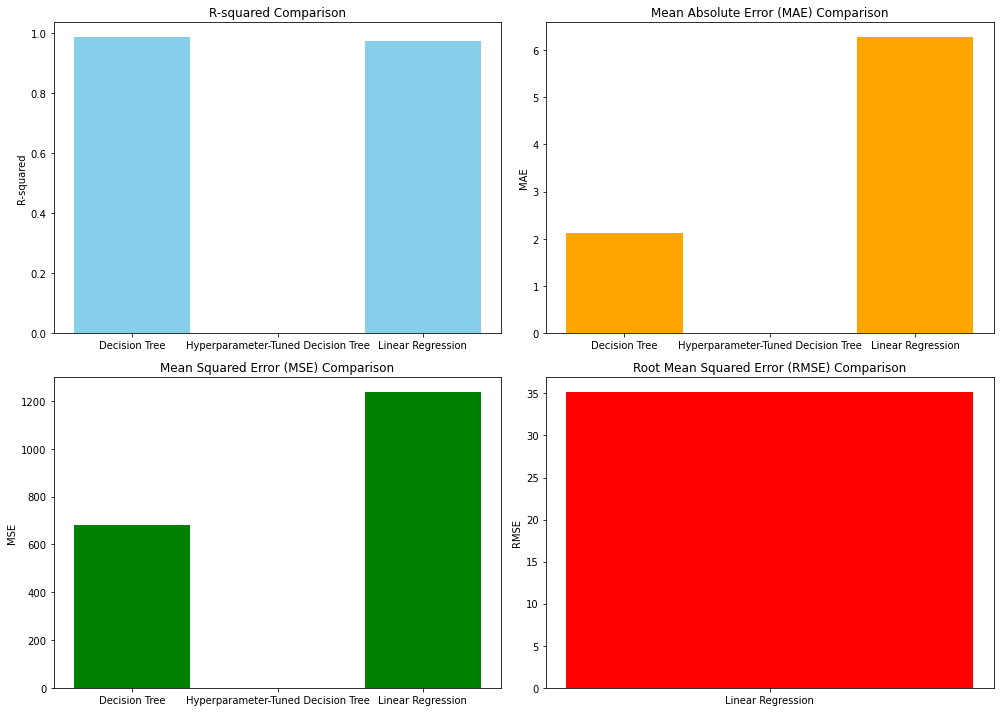

                                Model  R-squared   MAE      MSE   RMSE
0                       Decision Tree     0.9866  2.13   679.48    NaN
1  Hyperparameter-Tuned Decision Tree        NaN   NaN      NaN    NaN
2                   Linear Regression     0.9756  6.27  1238.37  35.19


In [129]:
# Define model performance data
model_comparison = {
    'Model': ['Decision Tree', 'Hyperparameter-Tuned Decision Tree', 'Linear Regression'],
    'R-squared': [0.9866, np.nan, 0.9756],
    'MAE': [2.13, np.nan, 6.27],
    'MSE': [679.48, np.nan, 1238.37],
    'RMSE': [np.nan, np.nan, 35.19]
}

# Create DataFrame
df_comparison = pd.DataFrame(model_comparison)

# Plotting the comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# R-squared Bar plot
axes[0, 0].bar(df_comparison['Model'], df_comparison['R-squared'], color='skyblue')
axes[0, 0].set_title('R-squared Comparison')
axes[0, 0].set_ylabel('R-squared')

# MAE Bar plot
axes[0, 1].bar(df_comparison['Model'], df_comparison['MAE'], color='orange')
axes[0, 1].set_title('Mean Absolute Error (MAE) Comparison')
axes[0, 1].set_ylabel('MAE')

# MSE Bar plot
axes[1, 0].bar(df_comparison['Model'], df_comparison['MSE'], color='green')
axes[1, 0].set_title('Mean Squared Error (MSE) Comparison')
axes[1, 0].set_ylabel('MSE')

# RMSE Bar plot (for Linear Regression only)
axes[1, 1].bar(df_comparison['Model'], df_comparison['RMSE'], color='red')
axes[1, 1].set_title('Root Mean Squared Error (RMSE) Comparison')
axes[1, 1].set_ylabel('RMSE')

plt.tight_layout()
plt.show()

# Display the DataFrame for quick reference
print(df_comparison)

Based on this analysis, the default Decision Tree model performs the best overall in predicting weather data, particularly in terms of explained variance (R²) and prediction accuracy (MAE and MSE).